In [14]:
# module import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 딥러닝 모델을 설계할때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
# 데이터 다운로드
train_dataset = datasets.MNIST(root='./'
                               , train=True,download=True,transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./'
                               , train=False,download=True,transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [5]:
# 데이터 확인1
for x_train,y_train in train_loader:
    print(f"x_train : {x_train.size()} type: {x_train.type()}")
    print(f"y_train : {y_train.size()} type: {y_train.type()}")
    break

x_train : torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train : torch.Size([32]) type: torch.LongTensor


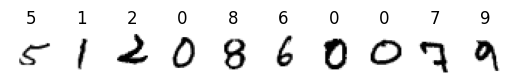

In [12]:
# 데이터 확인2
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.title(y_train[i].item()) 
    plt.imshow(x_train[i].numpy().reshape(28,28),cmap='gray_r')

In [32]:
# 모델 설계  L = 5  Linear 5
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        self.dropput_prob = 0.5
    def forward(self,x):   #히든층-출력함수-드랍아웃
        x = x.view(-1,28*28)  # 입력데이터를 2차원 행렬로 변경
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = torch.dropout(input=x, p=self.dropput_prob, train=self.training)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        x = torch.dropout(input=x, p=self.dropput_prob, train=self.training)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        x = torch.dropout(input=x, p=self.dropput_prob, train=self.training)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        x = torch.dropout(input=x, p=self.dropput_prob, train=self.training)
        x = self.fc5(x)
        x = torch.softmax(x,dim=1)
        return x

In [33]:
# model object, optimizer, loss function 생성
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)


In [41]:
# 학습함수 : 학습진행, 진행상태
def train(model, train_loader,optimizer):
    model.train()
    for idx,(images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad() # 기울기를 업데이트 하지 않는다.. 즉 고정한다.
        output = model(images)
        loss = criterion(output, labels)
        loss.backward() # 오류 역전파
        optimizer.step() # 오류 역전파 값을 적용한다
        if idx%100 == 0:
            print(f"loss : {loss.item()}")

In [42]:
# 평가 함수
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): #평가는 전방계산만 하고 역전파 안하기 때문에 가중치를 고정
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)            
            output = model(images)
            test_loss += criterion(output, labels).item()
            prediction = output.max(1,keepdim =True)[1]
            correct += prediction.eq(labels.view_as(prediction)).sum().item() 
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
# 학습진행
for epoch in range(1, EPOCHS+1):
    train(model,train_loader,optimizer)
    test_loss, test_accuracy = evaluate(model,test_loader)
    print(f"epoch : {epoch} loss : {test_loss}  accuracy : {test_accuracy}")

loss : 1.8386139869689941
loss : 1.936757206916809
loss : 1.9080429077148438
loss : 1.8327209949493408
loss : 1.8090133666992188
loss : 1.7756378650665283
loss : 1.8773103952407837
loss : 1.755112648010254
loss : 1.7906849384307861
loss : 1.6997504234313965
loss : 1.751420497894287
loss : 1.6301976442337036
loss : 1.6933231353759766
loss : 1.6983115673065186
loss : 1.7739601135253906
loss : 1.7165699005126953
loss : 1.7235798835754395
loss : 1.7195770740509033
loss : 1.599685549736023
epoch : 1 loss : 0.052694436490535734  accuracy : 77.58
loss : 1.7647455930709839
loss : 1.739149570465088
loss : 1.6506447792053223
loss : 1.7721878290176392
loss : 1.6190423965454102
loss : 1.6730597019195557
loss : 1.58197021484375
loss : 1.50101900100708
loss : 1.564404845237732
loss : 1.619600772857666
loss : 1.6976875066757202
loss : 1.6574597358703613
loss : 1.6217947006225586
loss : 1.763014793395996
loss : 1.639068603515625
loss : 1.6832005977630615
loss : 1.6517447233200073
loss : 1.650941491127

NameError: name 'd' is not defined